In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import itertools

In [3]:
# グラフの設定
fontsize_title = 25
fontsize_label = 20
max_xlin = 15

# サンプリング周波数
fs = 400

In [4]:
# CSVファイルを読み込む
path = "./logs/measurement_error/"
acc_file_name = f"{path}Accelerometer.csv"
gyro_file_name = f"{path}Gyroscope.csv"

df_acc = pd.read_csv(acc_file_name, header=0, names=(
    "time", "x", "y", "z"))
df_gyro = pd.read_csv(gyro_file_name, header=0, names=(
    "time", "x", "y", "z"))

df_acc["time"] = df_acc["time"]
df_gyro["time"] = df_gyro["time"]

<Figure size 640x480 with 0 Axes>

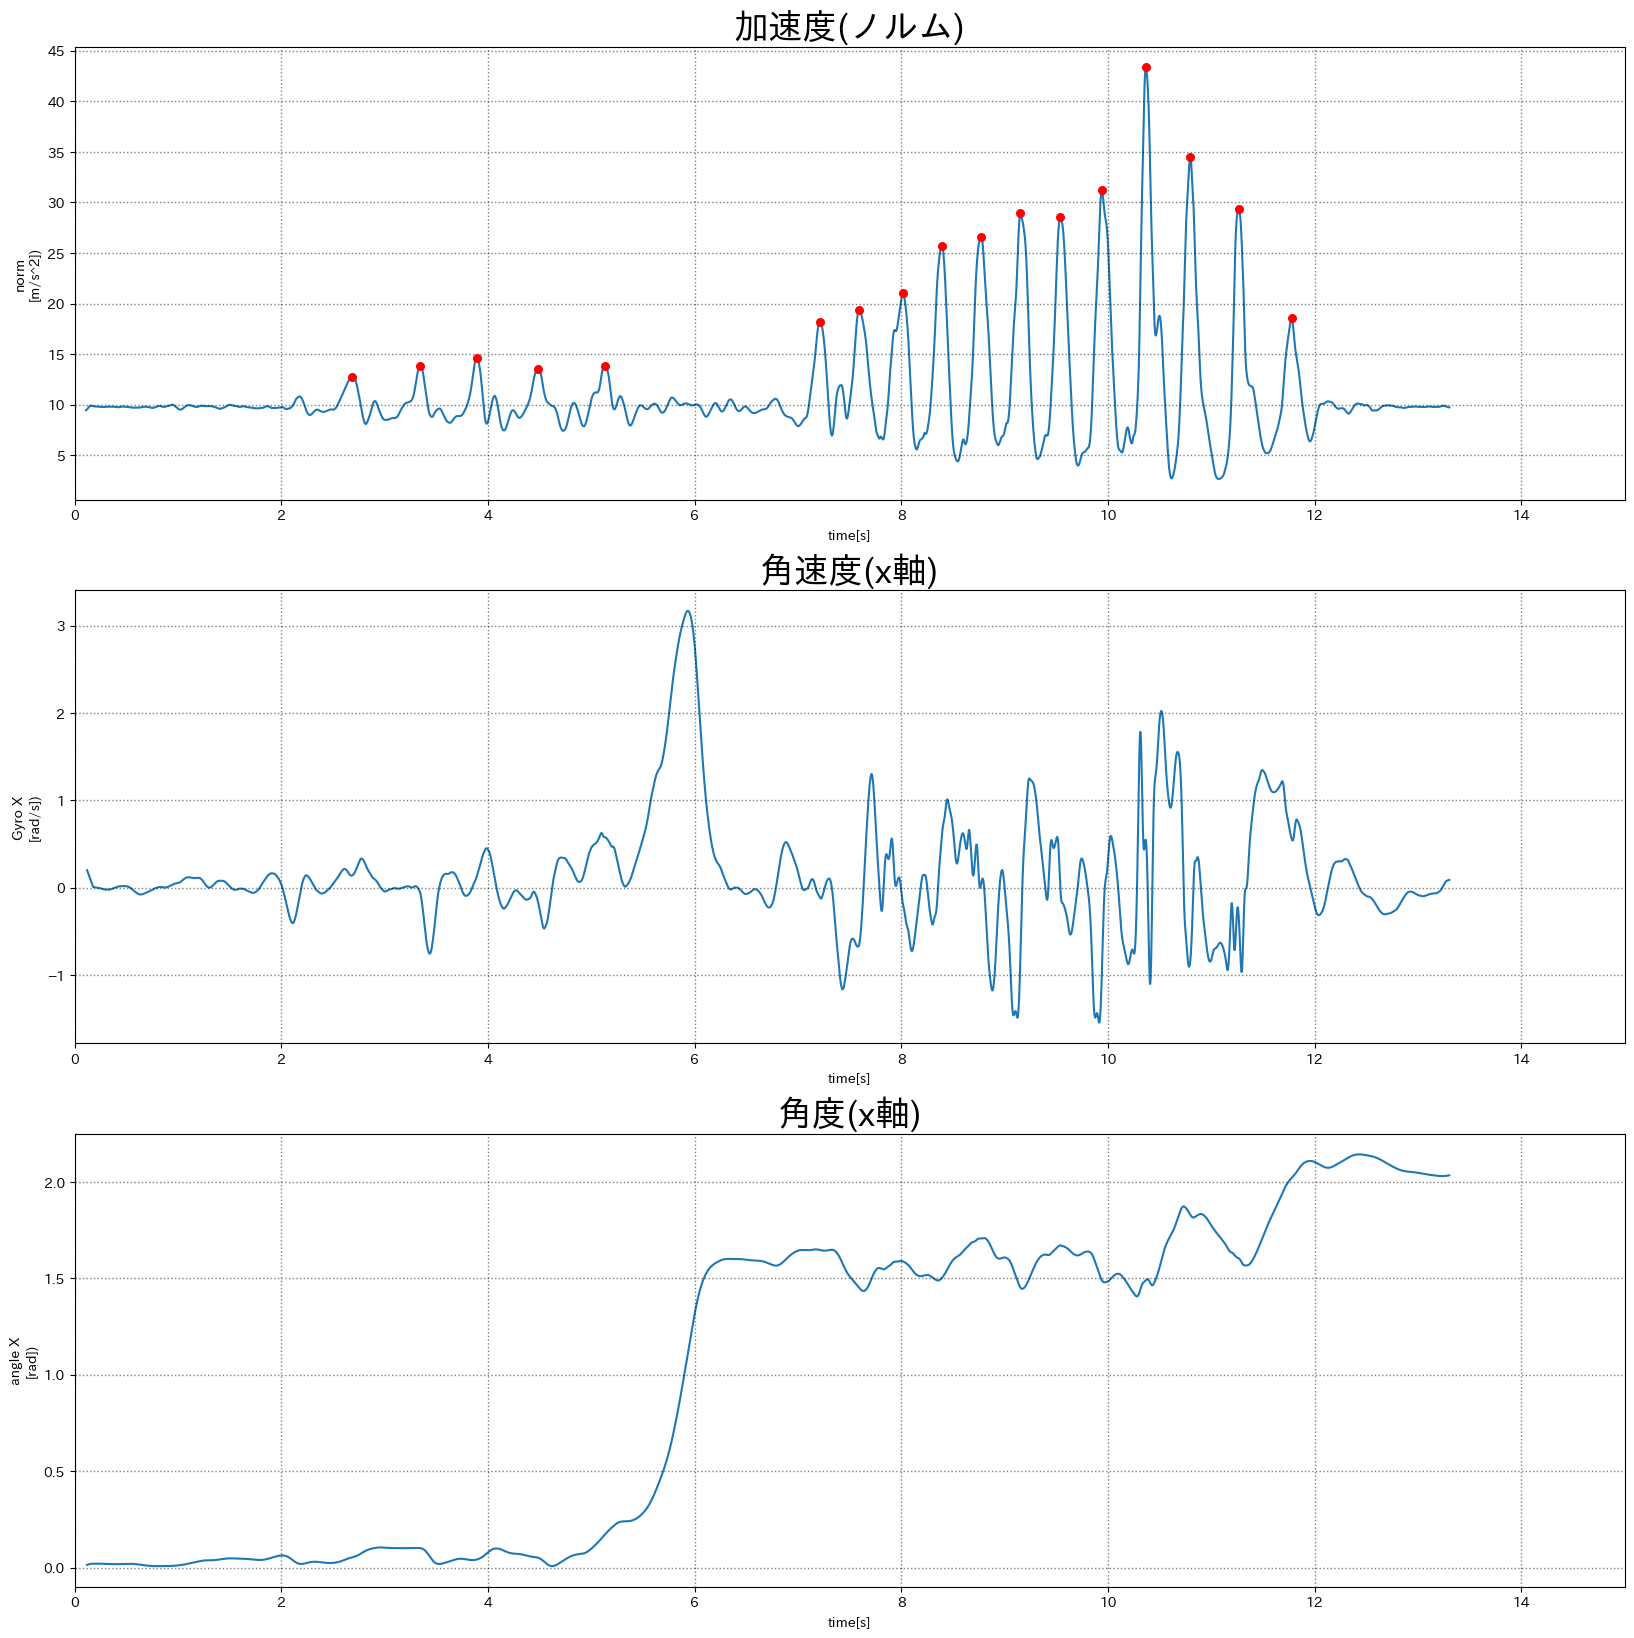

In [5]:
# ノルムを求める
df_acc['norm'] = np.linalg.norm(df_acc[['x', 'y', 'z']], axis=1)

# 角度を求める
df_gyro['angle'] = np.cumsum(df_gyro['x']) / fs

# window=10の移動平均
window = 40
df_acc['low_norm'] = df_acc['norm'].rolling(window=window).mean()
df_gyro['low_x'] = df_gyro['x'].rolling(window=window).mean()
df_gyro['low_angle'] = df_gyro['angle'].rolling(window=window).mean()

# グラフを描画する
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(20, 20))

## 加速度
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(df_acc['time'], df_acc['low_norm'], zorder=1)
ax1.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
ax1.set_title('加速度(ノルム)', fontdict={'size': fontsize_title})
ax1.set_xlim(0, max_xlin)
plt.xlabel('time[s]')
plt.ylabel('norm\n[m/s^2])')

### ピークを描画
peek, _ = signal.find_peaks(df_acc['low_norm'], distance=30, height=11, prominence=3.5)
ax1.scatter(df_acc['time'][peek], df_acc['low_norm'][peek], s=30, color='red', zorder=2)

## 角速度
ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(df_gyro['time'], df_gyro['low_x'], zorder=1)
ax2.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
ax2.set_title('角速度(x軸)', fontdict={'size': fontsize_title})
ax2.set_xlim(0, max_xlin)
plt.xlabel('time[s]')
plt.ylabel('Gyro X\n[rad/s])')

## 角度
ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(df_gyro['time'], df_gyro['low_angle'], zorder=1)
ax3.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
ax3.set_title('角度(x軸)', fontdict={'size': fontsize_title})
ax3.set_xlim(0, max_xlin)
plt.xlabel('time[s]')
plt.ylabel('angle X\n[rad])')

plt.show()


In [6]:
point_diff_data = ((0.61, 0), (0.61, 0), (0.61, 0), (0.61, 0), (0.61, 0), (0, 1.35),
                   (0, 1.63), (0, 1.22), (0, 1.60), (0, 1.64), (0, 1.31), (0, 1.82))

real_data = [(0, 0)]
for data in point_diff_data:
    real_data.append((real_data[-1][0] + data[0], real_data[-1][1] + data[1]))

real_data = np.array(real_data)


0.7881589575527497


(-0.5, 13.0)

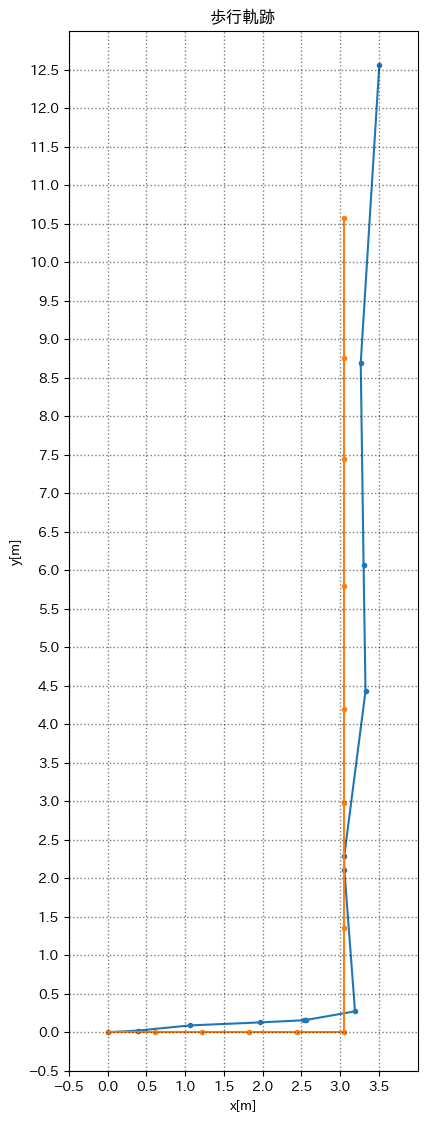

In [19]:
# 軌跡を描く
peek, _ = signal.find_peaks(df_acc['low_norm'], distance=30, height=11)

point = [[0, 0]]
for p in peek[0:12]:
    step = df_acc['low_norm'][p] * 0.269 -3.043
    x = step * np.cos(df_gyro['low_angle'][p]) + point[-1][0]
    y = step * np.sin(df_gyro['low_angle'][p]) + point[-1][1]

    point.append([x, y])

point = pd.DataFrame(data=point, columns=['x', 'y'])
point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]

# 2乗平均誤差を求める
diff = 0
num = min(len(real_data), len(point))
for i in range(num):
    diff += np.linalg.norm(real_data[i] - point.iloc[i])

print(diff/ num)

# グラフを描画する
size = ((-0.5, 4), (-0.5, 13))
plt.figure(figsize=(size[0][1]-size[0][0], size[1][1]-size[1][0]))

plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)
plt.plot(real_data[:, 0], real_data[:, 1], '.-', label='実際', zorder=1)

plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.xticks(np.arange(size[0][0], size[0][1], 0.5))
plt.yticks(np.arange(size[1][0], size[1][1], 0.5))
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])


In [13]:
# 最小のRMSEとなる一次関数を求める
peek, _ = signal.find_peaks(df_acc['low_norm'], distance=30, height=11)
min_ = {'rmse': 100, 'a': 0, 'b': 0}

for a in np.arange(0.25, 0.27, 0.001):
    for b in np.arange(-3.2, -3, 0.001):
        point = [[0, 0]]
        for p in peek[0:12]:
            step = df_acc['low_norm'][p] * a + b
            x = step * np.cos(df_gyro['low_angle'][p]) + point[-1][0]
            y = step * np.sin(df_gyro['low_angle'][p]) + point[-1][1]

            point.append([x, y])

        point = pd.DataFrame(data=point, columns=['x', 'y'])
        point['x'] = point['x'] - point['x'][0]
        point['y'] = point['y'] - point['y'][0]

        # 2乗平均誤差を求める
        diff = 0
        num = min(len(real_data), len(point))
        for i in range(num):
            diff += np.linalg.norm(real_data[i] - point.iloc[i])

        if min_['rmse'] > diff / num:
            min_['rmse'] = diff / num
            min_['a'] = a
            min_['b'] = b

print(min_['rmse'], min_['a'], min_['b'])


0.7881589575527493 0.269 -3.0430000000000175


In [9]:
# 2乗平均誤差を求める
diff = 0
num = min(len(real_data), len(point))
for i in range(num):
    diff += np.linalg.norm(real_data[i] - point.iloc[i])

print(diff/ num)


5.234526475299898


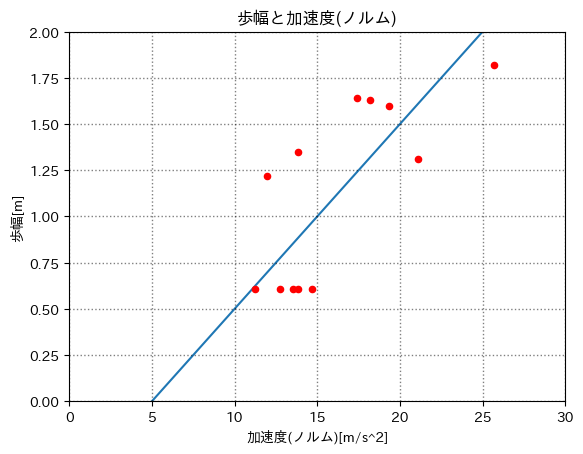

In [10]:
# 実際の歩幅をx軸, 加速度(ノルム)をy軸 としてプロット

peek, _ = signal.find_peaks(df_acc['low_norm'], distance=30, height=11)

height = []
for p in peek[0:12]:
    height.append(df_acc['low_norm'][p])

steps = (0.61, 0.61, 0.61, 0.61, 0.61, 1.35,
         1.63, 1.22, 1.60, 1.64, 1.31, 1.82)

x = np.arange(0, 30)
y = 0.1 * x - 0.5

plt.plot(x, y, '-', zorder=1)
plt.scatter(height, steps, s=20, color='red', zorder=2)
plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
plt.title('歩幅と加速度(ノルム)')
plt.xlabel('加速度(ノルム)[m/s^2]')
plt.ylabel('歩幅[m]')
plt.xlim(0, 30)
plt.ylim(0, 2)
plt.show()
